In [1]:
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Optimizer
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as tt

In [2]:
datasetPath = Path('../input/masked-facerecognition')
maskPath = datasetPath/'AFDB_masked_face_dataset/AFDB_masked_face_dataset'
nonMaskPath = datasetPath/'AFDB_face_dataset/AFDB_face_dataset'
#maskDF = pd.DataFrame()
path_dirs = [ [maskPath,1],[nonMaskPath,0] ] 


In [51]:
class Datasetarrangement():
    IMG_SIZE = 100
    LABELS = {'NON_MASKED': 0, 'MASKED': 1}
    training_data = []
    count = 0
    def make_training_data(self):
        for data_dir, label in path_dirs:
            for folder in tqdm(os.listdir(data_dir)):
                folder_path = os.path.join(data_dir, folder)
                for imgpath in os.listdir(folder_path):
                    self.count += 1                       
                    img_path = os.path.join(folder_path, imgpath)
                    img = cv2.imread(img_path)
                    self.training_data.append([np.array(img), label])
                    if label == 1:
                        self.LABELS['MASKED'] += 1 # counting number of masked images
                    if label == 0:
                        self.LABELS['NON_MASKED'] +=1
                    if self.count>3000:
                        self.count = 0
                        np.random.shuffle(self.training_data)
                        print(self.LABELS)
                        return
        
       

In [52]:
mask_nomask = Datasetarrangement()
mask_nomask.make_training_data()
training_data = mask_nomask.training_data

  2%|▏         | 8/460 [00:02<01:55,  3.91it/s]

{'NON_MASKED': 1602, 'MASKED': 1400}


In [53]:
img, lab = training_data[0]
print(img.shape)

(127, 127, 3)


In [56]:
class MaskDataset(Dataset):
    """ Masked faces dataset
        0 = 'no mask'
        1 = 'mask'
    """
    def __init__(self, train_data):
        self.train_data = train_data
        
        self.transformations = tt.Compose([
            tt.ToPILImage(),
            tt.Resize((32, 32)),
            tt.RandomHorizontalFlip(),
            tt.ToTensor(),
            tt.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5),inplace=True)
           
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')
        
        return [
                self.transformations(self.train_data[key][0]),
                torch.tensor(self.train_data[key][1])
            ]
        
    
    def __len__(self):
        return len(self.train_data)

In [58]:
Dataset = MaskDataset(training_data)
image, lab = Dataset[0]
print(image.shape)

torch.Size([3, 32, 32])


In [60]:
val_size = 500
test_size = 50
train_size = len(Dataset) - val_size-test_size

train_ds, val_ds, test_ds = torch.utils.data.random_split(Dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(2451, 500, 50)

In [61]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size*2, shuffle=True)
val_dl = DataLoader(val_ds, batch_size*2)

In [62]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

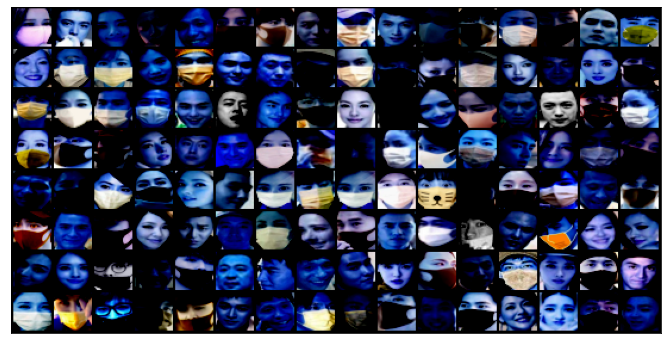

In [63]:
show_batch(train_dl)

In [64]:
input_size = 32*32
output_size = 2

In [65]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [66]:
class MaskDetectionModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 8 x 8

            nn.Flatten(), 
            nn.Linear(16384, 2056),
            nn.ReLU(),
            nn.Linear(2056, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 2))
        
    def forward(self, xb):
        return self.network(xb)


In [67]:
model = MaskDetectionModel()
model

MaskDetectionModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten()
    (13): Linear(in_features=16384, out_features=2056, bias=True)
    (14): ReLU()
    (15): Linear(in_features=2056, out_features=1024, bias=True)
    (16): ReLU()
    (17): Linear(in_features=1024, out_features=512, bias=True)
    (18): ReLU()
    (19): Linear(in_features=512, out_features=256, bias=Tru

In [68]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [69]:
device = get_default_device()
device

device(type='cuda')

In [70]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [71]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [72]:
model = to_device(MaskDetectionModel(), device)

In [73]:
evaluate(model, val_dl)

{'val_loss': 0.6963182091712952, 'val_acc': 0.43978986144065857}

In [74]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [75]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6732, val_loss: 0.2421, val_acc: 0.9345
Epoch [1], train_loss: 0.3056, val_loss: 0.2094, val_acc: 0.9287
Epoch [2], train_loss: 0.1858, val_loss: 0.1696, val_acc: 0.9463
Epoch [3], train_loss: 0.1593, val_loss: 0.1723, val_acc: 0.9484
Epoch [4], train_loss: 0.1315, val_loss: 0.1766, val_acc: 0.9443
Epoch [5], train_loss: 0.1137, val_loss: 0.1156, val_acc: 0.9681
Epoch [6], train_loss: 0.0901, val_loss: 0.1093, val_acc: 0.9738
Epoch [7], train_loss: 0.0723, val_loss: 0.0928, val_acc: 0.9721
Epoch [8], train_loss: 0.0582, val_loss: 0.0820, val_acc: 0.9699
Epoch [9], train_loss: 0.0596, val_loss: 0.1037, val_acc: 0.9625


In [76]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');


In [77]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

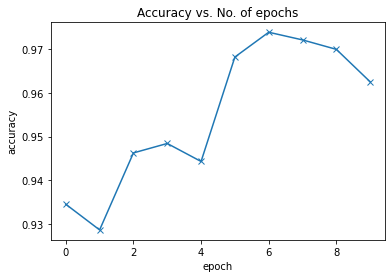

In [78]:
plot_accuracies(history)

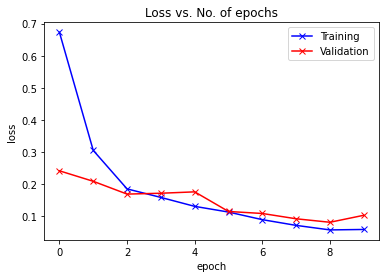

In [79]:
plot_losses(history)

In [80]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds

Label: tensor(1) , Predicted: tensor([1], device='cuda:0')


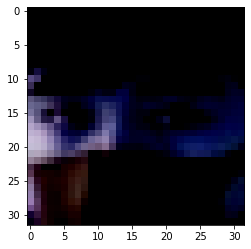

In [83]:
img, label = test_ds[48]
classes = ['Non-Masked','Masked']
plt.imshow(img.permute(1, 2,0))
print('Label:', classes[label], ', Predicted:', classes[predict_image(img, model)])